### Treść zadania

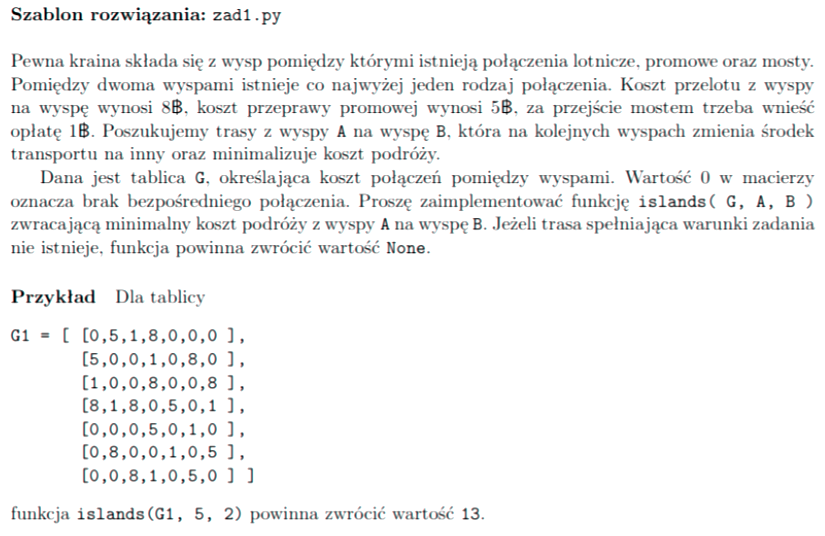

# Sposób I
## (Przemapowanie grafu i Dijkstra)

### Omówienie algorytmu

Tworzymy nowy graf, najlepiej w reprezentacji listowej, w którym każdy z wierzchołków wyjściowego grafu rozdzielamy na 3 wierzchołki w taki sposób, że do każdego prowadzą jedynie krawędzie wchodzące o tych samych wagach, a wszystkie krawędzie wychodzące mają wagi różne od wag krawędzi wchodzących. W ten sposób otrzymujemy graf, który będzie spełniał warunek zadania, że zawsze zmieniamy środek transportu (wagę krawędzi) po przejściu przez miasto (wierzchołek). Wówczas możemy już zastosować dowolny algorytm znajdowania najkrótszej ścieżki ważonej, czyli najlepiej przy nieujemnych wagach użyć algorytmu Dijkstry (można by się pokusić o BFS ze sztucznie dodawanymi wierzchołkami do kolejki, ale nie ma to sensu w tym przypadku, bo samo utworzenie nowego grafu zajmuje nam $ O(V^2) $ czasu (odczyt macierzy grafu z macierzy tyle czasu zabiera)).
###### Dokładniejsze omówienie poniższej implementacji
W pierwszym kroku rozdzielamy każdy wierzchołek na $ m $ wierzchołków, gdzie $ m $ jest liczbą różnych kosztów podróży (u nas w zadaniu $ m = 3 $). W tym celu tworzymy graf, który ma $ m \cdot V $ wierzchołków, gdzie każdy wierzchołek postaci $ u \cdot m + i $, gdzie $ u $ jest indeksem wierzchołka z wyjściowego grafu, $ i \in \{0, 1, 2, ..., m - 1 \} $ jest wierzchołkiem, do którego wchodzą wyłącznie krawędzie o wadze $ W[i] $, gdzie $ W[i] $ - posortowana tablica wag wszystkich krawędzi w grafie (cen różnych środków transportu). Z takiego wierzchołka wychodzą krawędzie do wszystkich tych wierzchołków, do których wychodziły krawędzie w grafie wyjściowym z wierzchołka $ u $ z wyłączeniem tych krawędzi, których waga jest taka sama jak waga krawędzi wchodzących do danego wierzchołka, czyli $ W[i] $. Wagi krawędzi musza być posortowane rosnąco, abyśmy mogli łatwo znaleźć indeks $ i $ (przesunięcie wierzchołka). W pętli przeglądamy graf (macierz) otrzymany na wejściu i jak napotkamy na krawędź, wywołujemy funkcję pomocniczą, która oblicza indeksy wierzchołka docelowego oraz wierzchołków źródłowych (na które został podzielony wierzchołek $ u $ grafu wyjściowego), do których ma być dodana ta krawędź.
<br><br>
Po takim przemapowaniu grafu, ponieważ mamy kilka możliwych wierzchołków startowych oraz kilka końcowych (nasze wierzchołki - startowy oraz końcowy - uległy rozdzieleniu, jak wszystkie inne), musimy je połaczyć z jednym wspólnym wierzchołkiem startowym (wierzchołki odpowiadające pierwotnemu wierzchołkowi startowemu), a także połączyć wszystkie wierzchołki końcowe krawędziami z nowym końcem. Dodajemy w tym celu krawędzie o wagach 0, aby nie zaburzyć kosztu podróży.
<br><br>
Dalej mamy już graf gotowy i używamy zwykłego algorytmu Dijkstry bez żadnych modyfikacji.

### Złożoność

###### Obliczeniowa:
$ O(V^2 + E \cdot (m + log(m)) + (m \cdot E) \cdot log(m \cdot V)) = | m = 3, E \le V^2 | = O(V^2 + E \cdot log(V)) $, gdzie $ m $ - liczba różnych wag krawędzi
###### Pamięciowa:
$ O(m \cdot (V + E)) = | m = 3 | = O(V + E) $ - tyle potrzeba miejsca na utworzenie nowego grafu, w którym będziemy mieli maksymalnie 3 razy więcej wierzchołków i krawędzi. (Graf otrzymany na wejściu traktuję jako dany i nie wliczam do złożoności)

### Implementacja

In [1]:
from queue import PriorityQueue


def binary_search_first(arr: 'sorted sequence', el: 'searched element') -> int:
    left_idx = 0
    right_idx = len(arr)-1
    
    while left_idx <= right_idx:
        mid_idx = (left_idx + right_idx) // 2
        if el > arr[mid_idx]:
            left_idx = mid_idx + 1
        else:
            right_idx = mid_idx - 1
            
    return left_idx if left_idx < len(arr) and arr[left_idx] == el else -1


def map_graph(G, W: 'sorted array of all edges weights'):
    n = len(G)
    m = len(W)
    G2 = [[] for _ in range(m * n)]
    
    def get_ind(u, v):
        weight = G[u][v]
        i = binary_search_first(W, weight)
        # Index of a vertex which edges are going into
        v_new = m * v + i
        # Indices of vertices which edges will be going out from
        u_new = [m * u + j for j in range(m) if j != i]
        return u_new, v_new
    
    for u in range(n):
        for v in range(n):
            if not G[u][v]: continue
            u_new_lst, v_new = get_ind(u, v)
            for u_new in u_new_lst:
                G2[u_new].append((v_new, G[u][v]))
                
    return G2


def add_begin_end_vertices(G, s, t, m):
    n = len(G)
    
    G.append([(s * m + i, 0) for i in range(m)])
    G.append([])
    
    for i in range(m):
        G[t * m + i].append((n + 1, 0))
    
    return n, n + 1


def dijkstra(G: 'graph represented by adjacency lists', s: 'start', t: 'target'):
    n = len(G)
    inf = float('inf')
    weights = [inf] * n
    to_relax = n
    pq = PriorityQueue()
    pq.put((0, s))

    while not pq.empty() and to_relax:
        min_w, u = pq.get()
        # We will find the minimum total weight path only once so the
        # code below this if statement will be executed only once
        if min_w < weights[u]:
            to_relax -= 1
            weights[u] = min_w
            if u == t: return weights[t]
            # Add all the neighbours of the u vertex to the priority queue
            for v, weight in G[u]:
                if weights[v] == inf:
                    pq.put((weights[u] + weight, v))
                
    return None


def islands(G: 'graph represented by adjacency matrix', a: 'begin city', b: 'target city'):
    W = [1, 5, 8]  # Koszty traktuję jako dane, ponieważ są jawnie podane w poleceniu
                   # Koszty muszą być posortowane rosnąco
    m = len(W)
    G2 = map_graph(G, W)
    s, t = add_begin_end_vertices(G2, a, b, m)
    return dijkstra(G2, s, t)

###### Kilka testów

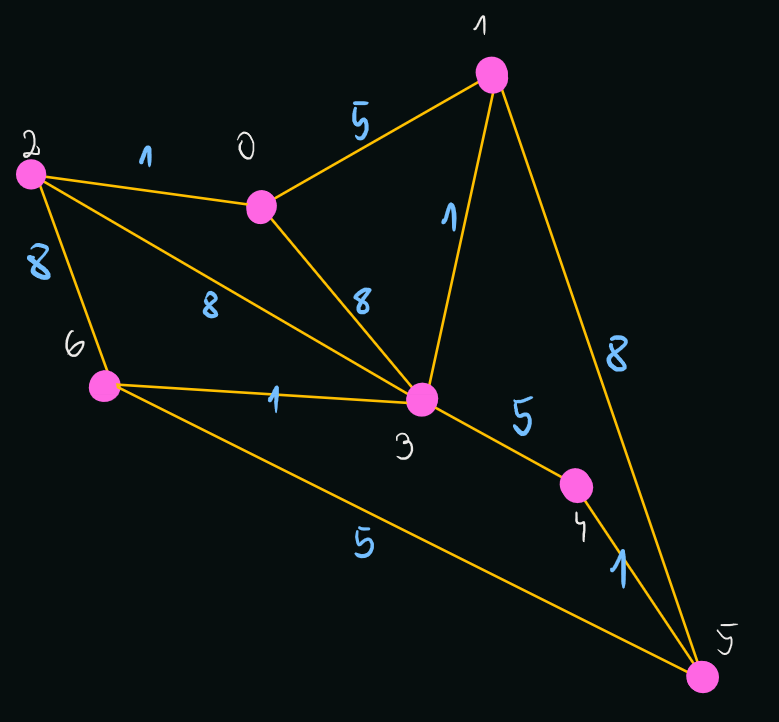

In [2]:
G = [[0,5,1,8,0,0,0],
     [5,0,0,1,0,8,0],
     [1,0,0,8,0,0,8],
     [8,1,8,0,5,0,1],
     [0,0,0,5,0,1,0],
     [0,8,0,0,1,0,5],
     [0,0,8,1,0,5,0]]

print(islands(G, 5, 2))
print(islands(G, 5, 0))

13
12


### (Dodatkowo) Odtwarzanie ścieżki

In [3]:
from queue import PriorityQueue


def binary_search_first(arr: 'sorted sequence', el: 'searched element') -> int:
    left_idx = 0
    right_idx = len(arr)-1
    
    while left_idx <= right_idx:
        mid_idx = (left_idx + right_idx) // 2
        if el > arr[mid_idx]:
            left_idx = mid_idx + 1
        else:
            right_idx = mid_idx - 1
            
    return left_idx if left_idx < len(arr) and arr[left_idx] == el else -1


def map_graph(G, W: 'sorted array of all edges weights'):
    n = len(G)
    m = len(W)
    G2 = [[] for _ in range(m * n)]
    
    def get_ind(u, v):
        weight = G[u][v]
        i = binary_search_first(W, weight)
        # Index of a vertex which edges are going into
        v_new = m * v + i
        # Indices of vertices which edges will be going out from
        u_new = [m * u + j for j in range(m) if j != i]
        return u_new, v_new
    
    for u in range(n):
        for v in range(n):
            if not G[u][v]: continue
            u_new_lst, v_new = get_ind(u, v)
            for u_new in u_new_lst:
                G2[u_new].append((v_new, G[u][v]))
                
    return G2


def add_begin_end_vertices(G, s, t, m):
    n = len(G)
    
    G.append([(s * m + i, 0) for i in range(m)])
    G.append([])
    
    for i in range(m):
        G[t * m + i].append((n + 1, 0))
    
    return n, n + 1


def dijkstra(G: 'graph represented by adjacency lists', s: 'start', t: 'target'):
    n = len(G)
    inf = float('inf')
    weights = [inf] * n
    parents = [None] * n
    to_relax = n
    pq = PriorityQueue()
    pq.put((0, s, None))

    while not pq.empty() and to_relax:
        min_w, u, parent = pq.get()
        # We will find the minimum total weight path only once so the
        # code below this if statement will be executed only once
        if min_w < weights[u]:
            to_relax -= 1
            weights[u] = min_w
            parents[u] = parent
            if u == t: break
            # Add all the neighbours of the u vertex to the priority queue
            for v, weight in G[u]:
                if weights[v] == inf:
                    pq.put((weights[u] + weight, v, u))
    # If a loop wasn't broken, there is no path to the target
    else: return [], -1
    
    return parents, weights[t]


def restore_path(parents, t, m):
    path = []
    
    t = parents[t]  # Skip the last vertex as it is artificially added
    
    while parents[t] is not None:  # Skip the first vertex as it is artificially added
        path.append(t // m)  # Get the original index
        t = parents[t]    
        
    reverse(path)
    return path


def reverse(A):
    n = len(A)
    for i in range(n // 2):
        swap(A, i, n - i - 1)
        
    
def swap(A, i, j):
    A[i], A[j] = A[j], A[i]
        

def islands(G: 'graph represented by adjacency matrix', a: 'begin city', b: 'target city'):
    W = [1, 5, 8]  # Koszty traktuję jako dane, ponieważ są jawnie podane w poleceniu
                   # Koszty muszą być posortowane rosnąco
    m = len(W)
    G2 = map_graph(G, W)
    s, t = add_begin_end_vertices(G2, a, b, m)
    parents, cost = dijkstra(G2, s, t)
    # If there is no path
    if not parents: return -1, []
    return cost, restore_path(parents, t, m)

###### Kilka testów

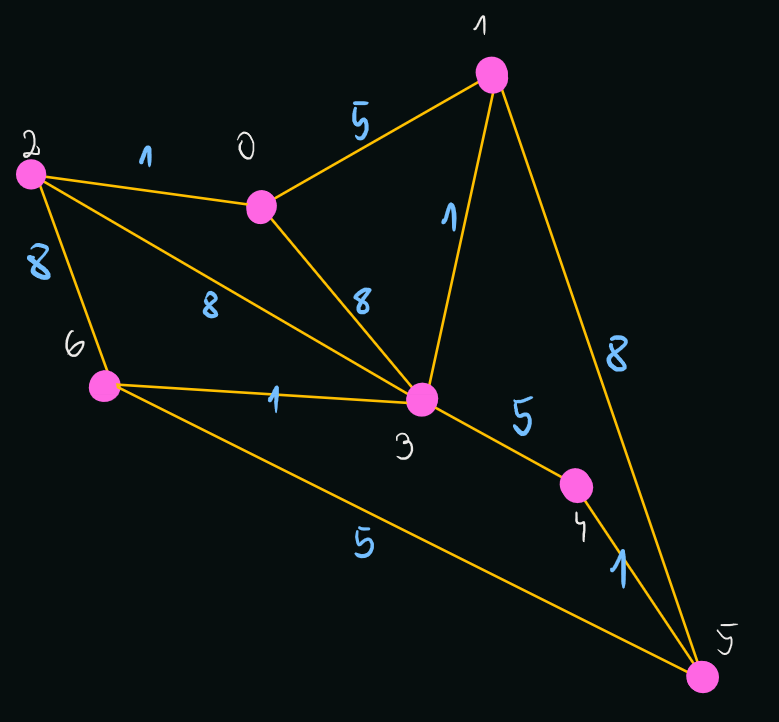

In [4]:
G = [[0,5,1,8,0,0,0],
     [5,0,0,1,0,8,0],
     [1,0,0,8,0,0,8],
     [8,1,8,0,5,0,1],
     [0,0,0,5,0,1,0],
     [0,8,0,0,1,0,5],
     [0,0,8,1,0,5,0]]

print(islands(G, 5, 2))  # Jest kilka możliwych ścieżek
print(islands(G, 5, 0))

(13, [5, 4, 3, 1, 0, 2])
(12, [5, 4, 3, 1, 0])


# Sposób II
## (Dijkstra w zależności od rodzica)

Ponieważ wykorzystuję algorytm, Dijkstry, który działa na grafach w reprezentacji macierzowej w czasie $ O(V^2) $ bez użycia kolejki priorytetowej, jest on nieco skomplikowany, jeżeli chodzi o implementację. Generalnie, tworzymy tablicę $ weights $ o wymiarach $ V \times m $, gdzie $ m $ - liczba różnych środków transportu (liczba różnych wag krawędzi) (u nas $ m = 3 $). $ weights[u][i] $ oznaczać będzie sumaryczną wagę najtańszej ścieżki, prowadzącej od wierzchołka startowego do wierzchołka $ u $, kończącej się na krawędzi o wadze $ W[i] $ (konieczne jest przemapowanie wag z użyciem wyszukiwania binarnego (lub w normalnym życiu jakiejś hashmapy, ale nam nie wolno). Ponieważ może być kilka ścieżek o najmniejszej wadze równocześnie, przy pomocy funkcji $ get\_min\_weight\_vertices $, która zastępuje kolejkę priorytetową, będziemy zawsze odfiltrowywać te wierzchołki, do których w danym momencie prowadzą najkrótsze ścieżki, a następnie będziemy je usuwać z listy odsyłaczowej (więcej szczegółów w pliku z implementacją i omówieniem algorytmu Dijkstry <a href="../../Zadania z wykładu/Algorytmy grafowe/[Grafowe] Algorytm Dijsktry - najkrótsze ścieżki jeden do wszystkich, tylko nieujemne wagi.ipynb#dijkstra-matrix">TUTAJ</a>).
###### Omówienie pomysłu z BIT Algo:
<div>
    <video src="../video/BIT_spotkanie11_zadanie1.mp4" controls style="width: 100%; height: 100%; padding: 0; margin: 0 auto;"></video>
</div>

### Implementacja #1
##### (Dla macierzowej reprezentacji grafu z wykorzystaniem Dijkstry bez kolejki)

#### Złożoność

###### Obliczeniowa:
$ O(V^2 \cdot (m + log(m))) = | m = 3 | = O(V^2) $, gdzie $ m $ - liczba różnych wag krawędzi
###### Pamięciowa:
$ O(m \cdot (V)) = | m = 3 | = O(V) $ - tyle potrzeba miejsca na stworzenie listy odsyłaczowej wierzchołków

#### Kod

In [5]:
def binary_search_first(arr: 'sorted sequence', el: 'searched element') -> int:
    left_idx = 0
    right_idx = len(arr)-1
    
    while left_idx <= right_idx:
        mid_idx = (left_idx + right_idx) // 2
        if el > arr[mid_idx]:
            left_idx = mid_idx + 1
        else:
            right_idx = mid_idx - 1
            
    return left_idx if left_idx < len(arr) and arr[left_idx] == el else -1


class Node:
    def __init__(self, idx=None, prev_i=None):
        self.prev_i = prev_i  # Index of the previous mean of transport weight
        self.next = None
        self.idx = idx


def vertices_to_process_ll(n, reps):
    head = Node()
    tail = head
    for u in range(n):
        # Skip the starting vertex
        for i in range(reps):
            tail.next = Node(u, i)
            tail = tail.next
    return head


def get_min_weight_vertices(head, weights):
    if not head.next: return []  # If no more vertices are remaining
    
    m = len(weights[0])
    # Find a vertex of the lowest weight
    prev = head
    min_w = float('inf')
    min_arr = []
    to_remove_prev = []
    
    while prev.next:
        u = prev.next.idx
        i = prev.next.prev_i
        if weights[u][i] < min_w:
            min_w = weights[u][i]
            min_arr = [(u, i)]
            to_remove_prev = [prev]
        elif weights[u][i] == min_w:
            min_arr.append((u, i))
            to_remove_prev.append(prev)
        prev = prev.next
        
    # Remove vertices of the lowest weight
    for i in range(len(to_remove_prev) - 1, -1, -1):
        prev = to_remove_prev[i]
        prev.next = prev.next.next
    
    return min_arr


def dijkstra(G: 'graph represented by adjacency matrix', 
             W: 'array of edges weights', 
             s: 'start', 
             t: 'target'):
    m = len(W)
    n = len(G)
    inf = float('inf')
    W.sort()
    # Store information about vertices which haven't been processed yet
    to_process = vertices_to_process_ll(n, len(W))
    parents    = [[None] * m for _ in range(n)]
    weights    = [[inf] * m for _ in range(n)]
    # Set initial weights of the start vertex to 0
    for i in range(m): weights[s][i] = 0
    res_i = None
        
    # Loop till a path wasn't found
    while res_i is None:
        # Find a vertex of the minimum total weight path
        to_check = get_min_weight_vertices(to_process, weights)
        # Otherwise, relax all neighbours of vertices with the lowest path weight
        for u, prev_i in to_check:
            # Break if the next vertex to process is the target vertex as we have 
            # already found a shortest path to this vertex before (or there is no
            # path to the target)
            if u == t:
                if weights[u][prev_i] == inf: return (None,) * 3
                res_i = prev_i
                break
            # Iterate over the vertice's neighbours and update their wieghts
            # (enter only these vertices which can be entered)
            for v in range(n):
                # Skip if no edge (0 means not edge) or if a weight of an edge is the
                # same as a weight of the previous edge
                if not G[u][v] or G[u][v] == W[prev_i]: continue
                # Update the weight of a path to the vertex v that ends with an edge
                # of the weight G[u][v] if found a better one
                i = binary_search_first(W, G[u][v])
                if weights[u][prev_i] + G[u][v] < weights[v][i]:
                    weights[v][i] = weights[u][prev_i] + G[u][v]
                    parents[v][i] = (u, prev_i)
                
    return res_i, parents, weights


def restore_path(parents: 'array of parents', 
                 weights: 'array of paths weights', 
                 t: 'target vertex index', 
                 i: 'last edge index'):
    path = [t]
    
    entry = parents[t][i]
    while entry:
        t, i = entry 
        path.append(t)
        entry = parents[t][i]
        
    reverse(path)
    return path


def reverse(A):
    n = len(A)
    for i in range(n // 2):
        swap(A, i, n - i - 1)
        
    
def swap(A, i, j):
    A[i], A[j] = A[j], A[i]
    

def islands(G: 'graph represented by adjacency matrix', a: 'begin city', b: 'target city'):
    W = [1, 5, 8]  # Koszty traktuję jako dane, ponieważ są jawnie podane w poleceniu
                   # Koszty muszą być posortowane rosnąco
    res_i, parents, weights = dijkstra(G, W, a, b)
    # If there is no path
    if parents is None: return None
    # Return the result
    return weights[b][res_i], restore_path(parents, weights, b, res_i)

###### Kilka testów

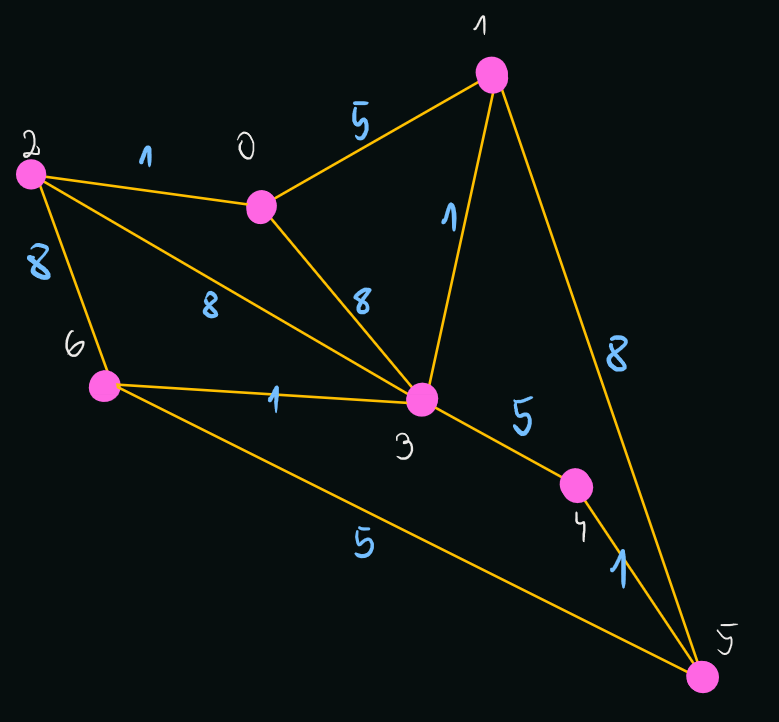

In [6]:
G = [[0,5,1,8,0,0,0],
     [5,0,0,1,0,8,0],
     [1,0,0,8,0,0,8],
     [8,1,8,0,5,0,1],
     [0,0,0,5,0,1,0],
     [0,8,0,0,1,0,5],
     [0,0,8,1,0,5,0]]

print(islands(G, 5, 2))
print(islands(G, 5, 0))

(13, [5, 4, 3, 1, 0, 2])
(12, [5, 4, 3, 1, 0])


### Implementacja #2
##### (Dla listowej reprezentacji grafu z wykorzystaniem Dijkstry z kolejką)

Najłatwiejsza spośród wszystkich implementacji.

#### Złożoność

###### Obliczeniowa:
$ O(E \cdot (m + log(m)) \cdot log(V)) = | m = 3 | = O(E \cdot log(V)) $, gdzie $ m $ - liczba różnych wag krawędzi
###### Pamięciowa:
$ O(m \cdot (V)) = | m = 3 | = O(V) $ - jeżeli na wejściu otrzymujemy graf w postaci list sąsiedztwa

#### Kod

In [7]:
from queue import PriorityQueue


def binary_search_first(arr: 'sorted sequence', el: 'searched element') -> int:
    left_idx = 0
    right_idx = len(arr)-1
    
    while left_idx <= right_idx:
        mid_idx = (left_idx + right_idx) // 2
        if el > arr[mid_idx]:
            left_idx = mid_idx + 1
        else:
            right_idx = mid_idx - 1
            
    return left_idx if left_idx < len(arr) and arr[left_idx] == el else -1


def dijkstra(G: 'graph represented by adjacency lists', 
             W: 'array of edges weights', 
             s: 'start', 
             t: 'target'):
    m = len(W)
    n = len(G)
    inf = float('inf')
    W.sort()
    to_relax = m * n
    parents = [[None] * m for _ in range(n)]
    weights = [[inf] * m for _ in range(n)]
    pq = PriorityQueue()
    # Set initial weights of the start vertex to 0
    for i in range(m): 
        pq.put((0, s, i, None))
        
    res_i = 0

    while not pq.empty() and to_relax:
        # Poll the vertex with the shortest total distance
        min_w, u, prev_i, parent_tup = pq.get()
        
        if min_w < weights[u][prev_i]:
            weights[u][prev_i] = min_w
            parents[u][prev_i] = parent_tup
            if u == t: 
                res_i = prev_i
                break
            to_relax -= 1
            # Add all the neighbours that we can enter from the current
            # vertex to the priority queue
            for v, weight in G[u]:
                if weight != W[prev_i]:
                    pq.put((min_w + weight, v, binary_search_first(W, weight), (u, prev_i)))
    
    # If there is not path, return None
    if not to_relax or weights[t][res_i] == inf: return (None,) * 2
        
    return res_i, parents, weights


def restore_path(parents: 'array of parents', 
                 weights: 'array of paths weights', 
                 t: 'target vertex index', 
                 i: 'last edge index'):
    path = [t]
    
    entry = parents[t][i]
    while entry:
        t, i = entry 
        path.append(t)
        entry = parents[t][i]
        
    reverse(path)
    return path


def reverse(A):
    n = len(A)
    for i in range(n // 2):
        swap(A, i, n - i - 1)
        
    
def swap(A, i, j):
    A[i], A[j] = A[j], A[i]


def islands(G: 'graph represented by adjacency lists', a: 'begin city', b: 'target city'):
    W = [1, 5, 8]  # Koszty traktuję jako dane, ponieważ są jawnie podane w poleceniu
                   # Koszty muszą być posortowane rosnąco
    res_i, parents, weights = dijkstra(G, W, a, b)
    # If there is no path
    if parents is None: return None
    # Return the result
    return weights[b][res_i], restore_path(parents, weights, b, res_i)

###### Kilka testów

##### Pomocnicze

In [8]:
def undirected_weighted_graph_list(E: 'array of edges'):
    # Find a number of vertices
    n = 0
    for e in E:
        n = max(n, e[0], e[1])
    n += 1
    # Create a graph
    G = [[] for _ in range(n)]
    for e in E:
        G[e[0]].append((e[1], e[2]))
        G[e[1]].append((e[0], e[2]))
    return G

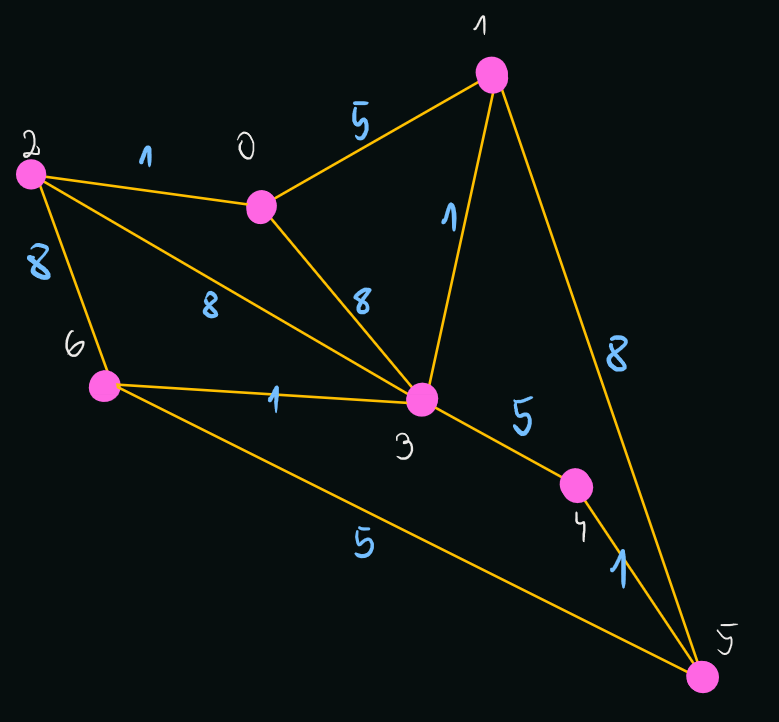

In [9]:
E = [(0, 1, 5), (0, 2, 1), (0, 3, 8), (1, 0, 5), (1, 3, 1), (1, 5, 8), (2, 0, 1), (2, 3, 8), (2, 6, 8), 
     (3, 0, 8), (3, 1, 1), (3, 2, 8), (3, 4, 5), (3, 6, 1), (4, 3, 5), (4, 5, 1), (5, 1, 8), (5, 4, 1), 
     (5, 6, 5), (6, 2, 8), (6, 3, 1), (6, 5, 5)]
G = undirected_weighted_graph_list(E)

print(islands(G, 5, 2))
print(islands(G, 5, 0))

(13, [5, 4, 3, 1, 0, 2])
(12, [5, 4, 3, 1, 0])
